In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt5
%matplotlib inline

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
from read-data import *
import numpy as np
import os
import math
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

# plt.style.use('ggplot')
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [2.12, 1.6]

# Figure sizes
default  = np.array([3.3,   2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
flhh  = np.array([4.75,  1.25])
EXP_list = [exp_folder.split('experiment_')[-1][:-1] for exp_folder in sorted(glob.glob('%s/*/' % datadir))]

EXP_drop = widgets.Dropdown(
    options=EXP_list,
    value=EXP_list[-1],
    description='Experiment:',
    disabled=False,
)

EXP_multiple = widgets.SelectMultiple(
    options=EXP_list,
    value=[EXP_list[-1]],
    #rows=10,
    description='Experiment:',
    disabled=False,
)


figfolder = 'plots'
display(EXP_drop)

ModuleNotFoundError: No module named 'read_data'

## Time elapsed between blocks

SelectMultiple(description='Experiment:', index=(24,), options=('/home/eksander/geth-argos/MarketForaging/resu…

Experiment datasets: test120_hotspot


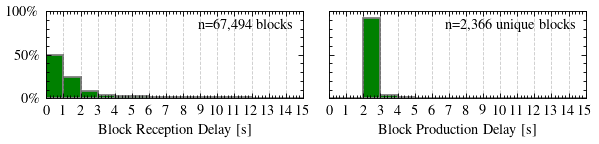

In [18]:
display(EXP_multiple)
EXP = EXP_multiple.value
# display(EXP_drop)
# EXP = EXP_drop.value
print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df(EXP, 'block')
# df = df.get_param(df,'generic_params','block_period')
XMAX = 15

###############################################################
# Process the dataframe  
bins = range(0, XMAX+1, 1)

# Create plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=flhh)
hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax[0].bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[0].grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax[0].text(XMAX-0.5,0.8,'n=%s blocks' % format(len(df), ',d'),ha='right')
# ax[0].set_title('Time elapsed between\nblock production and reception\n(%s blocks)' % len(df))

ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax[0].set_xticks(bins)
ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[0].set_xlabel('Block Reception Delay  [s]')

###############################################################
# Process the dataframe  
df = df.drop_duplicates('HASH')
df = trim_chain(df, 10).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax[1].bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
# ax[1].set_title()
ax[1].text(XMAX-0.5,0.8,'n=%s unique blocks' % format(len(df), ',d'),ha='right')
ax[1].grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax[1].set_xticks(bins)
ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[1].set_xlabel('Block Production Delay  [s]')

# Save plot
# fig.set_figwidth(plt.rcParams['figure.figsize'][1]*0.75) 
fig.tight_layout()

plt.savefig("plots/multi/time_elapsed_both.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between block production to reception

Dropdown(description='Experiment:', index=34, options=('backup_test116_patchy_single_', 'test101', 'test102', …

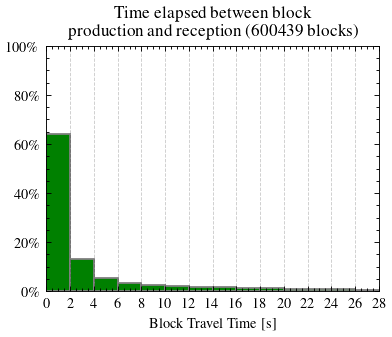

In [3]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')
df = df.get_param(df,'generic_params','block_period')

# Process the data  
bins = range(0, 30, df['block_period'].min())
# XX = df.groupby('HASH')['TELAPSED'].agg('max')
XX = df['TELAPSED']

# Create plot
ax = plt.axes()
hist, bins = np.histogram(XX, bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax.set_title('Time elapsed between block \n production and reception (%s blocks)' % len(XX))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Travel Time  [s]')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/time_elapsed_recept.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between consecutive blocks

Dropdown(description='Experiment:', index=17, options=('backup_test116_patchy_single_', 'test101', 'test102', …

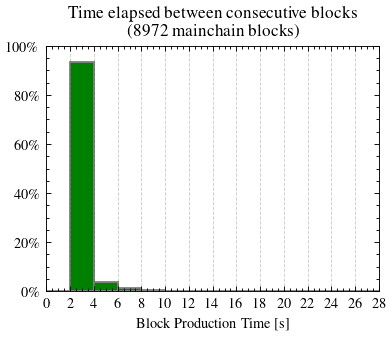

In [6]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')

# Process the dataframe  
df = df.get_param(df,'generic_params','block_period')
bins = range(0, 30, df['block_period'].min())

df = df.drop_duplicates('HASH')
df = trim_chain(df, 8).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.set_title('Time elapsed between consecutive blocks \n (%s mainchain blocks)' % len(df))
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Production Time  [s]')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/time_elapsed_prod.png", dpi=600)
plt.show()

## Local memory occupied by chaindata

Dropdown(description='Experiment:', index=24, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

array([25])

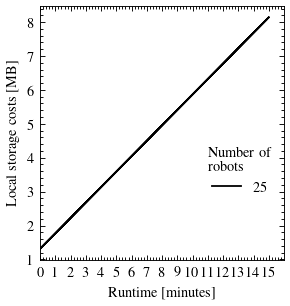

In [14]:
# display(EXP_multiple)
# EXP = EXP_multiple.value
display(EXP_drop)
# EXP = EXP_drop.value
# print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df(EXP, 'extra', exclude_patterns = ['greedy'])
df = df.get_param(df, 'generic_params', 'num_robots', alias = 'NROB')
display(df['NROB'].unique())
# Process the dataframe  
df = df.groupby(['NROB']).apply(lambda x: LinearRegression(x, 'TIME', 'MB'))

# Create plot
ax = plt.axes()
df['TIME_M'] = df['TIME']/60
df.set_index(['TIME_M']).groupby(['NROB'])['LREG'].plot(ax = ax, figsize = hlwidth)
# df.set_index(['TIME']).groupby(['EXP', 'REP', 'ID'])['MB'].plot(ax = ax, color='gray', label='_nolegend_', linewidth=0.2, alpha = 0.1, zorder=0)

# Edit plot
xmax = math.ceil(df['TIME'].max()/60)
xticks = range(0,xmax,1)
ax.set_xlim(xmin=0,xmax = xmax)
ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Local storage costs [MB]')
ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()

## Value Collected Over Distance Traveled 

Dropdown(description='Experiment:', index=21, options=('backup_test116_patchy_single_', 'test101', 'test102', …

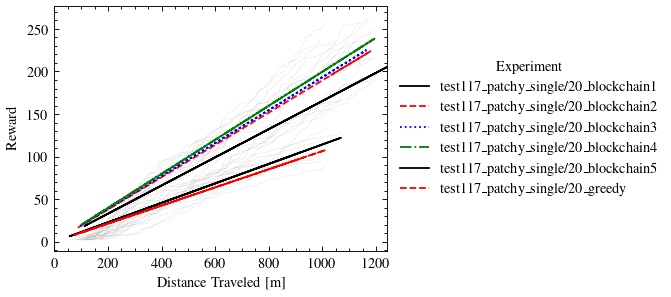

In [3]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')

# Axis data options
X_axis = 'DIST'

# Process the dataframe
df = df.groupby(['EXP']).apply(lambda x: LinearRegression0(x, X_axis, 'VALUE'))
# df = df[df['CONTROLLER'] == 'blockchain3']

# Create plot
ax = plt.axes()
df.set_index(X_axis).groupby(['EXP'])['LREG'].plot(ax=ax)
df.set_index(X_axis).groupby(['EXP','REP'])['VALUE'].plot(ax=ax, label='_nolegend_', color='gray', linestyle = '-', linewidth=0.2, alpha=0.3, zorder=0)

# Edit plot
ax.set_xlim(xmin=0,xmax = df[X_axis].max())
ax.set_ylabel('Reward')
if X_axis == 'DIST':
    ax.set_xlabel('Distance Traveled [m]')
else:
    ax.set_xlabel('Time [s]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Experiment')

## Efficiency (boxplot)

Dropdown(description='Experiment:', index=23, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

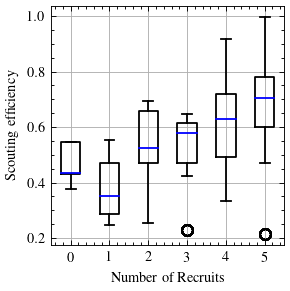

In [8]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
YY = 'SCOUT_DIST'
XX = 'Recruits'
BP = 'Robots'
yl = 'Scouting efficiency'
fs = hlwidth
# df = df.query('Recruits in [0,1]')
df = df.query('Robots==25')

# Process the data
df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharex=True, figsize=fs)

# Edit plot 
plt.suptitle('')
for axi in bp: axi.set_xlabel("Number of %s" % axi.get_xlabel())
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('')   

# bp[0].set_title('No Blockchain (Individualist)')
# bp[1].set_title('Blockchain (Individualist)')
plt.gcf().tight_layout()

plt.savefig("plots/experiment_"+EXP+"/efficiency_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()


## Total Value Collected (boxplot)

Dropdown(description='Experiment:', index=23, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

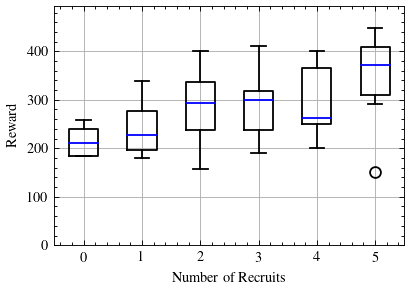

In [7]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
XX = 'Recruits'
BP = 'Robots'
YY = 'VALUE'
yl = 'Reward'
fs = default

# df = df.query('Robots==20')
# df = df.query('Recruits==0 or Recruits==1')

# Process the data  
df = df.groupby(['Robots', 'Recruits', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))

# Edit plot 
plt.suptitle('')
for axi in bp: axi.set_xlabel("Number of %s" % axi.get_xlabel())
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('') 
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
# bp[0].set_title('Individualist (no blockchain)')
# bp[1].set_title('Individualist (blockchain)')
plt.gcf().tight_layout()

plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

Dropdown(description='Experiment:', index=23, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

KeyError: 'SCOUT_DIST'

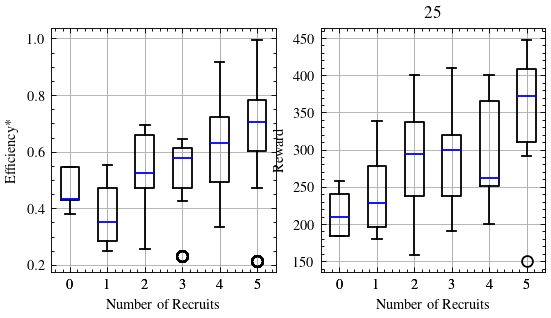

In [10]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Create figure
fs = flwidth
fig, axes = plt.subplots(1,2, sharex=True, figsize=fs)

######################################
# Plot options
LR = 'SCOUT_DIST'
XX = 'Recruits'
BP = 'Robots'
df = df.query('Robots==25')

# Process the dataframe  
df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, LR, 'VALUE'))

# Create plot

bp = df.groupby(BP).boxplot(column=['COEFS'], by = XX, ax=axes[0])

# Edit plot 
plt.suptitle('')
for axi in bp: axi.set_xlabel("Number of %s" % axi.get_xlabel())
for axi in bp: axi.set_ylabel("Efficiency*")
for axi in bp: axi.set_title(None) 

######################################
# Plot options
XX = 'Recruits'
BP = 'Robots'
df = df.query('Robots==25')

# Process the dataframe  
df = df.groupby(['Robots', 'Recruits', 'REP'], as_index=False).agg({'VALUE':'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=['VALUE'], by = XX, ax=axes[1])

# Edit plot 
plt.suptitle('')
for axi in bp: axi.set_xlabel("Number of %s" % axi.get_xlabel())
for axi in bp: axi.set_ylabel("Reward")
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.5)
for axi in bp: axi.set_title('') 
    
######################################
# Edit figure
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/total_value_bp_double.png", bbox_inches='tight', dpi=600)
plt.show()

## Distance Travelled Ratio (boxplot)

Dropdown(description='Experiment:', index=21, options=('backup_test116_patchy_single_', 'test101', 'test102', …

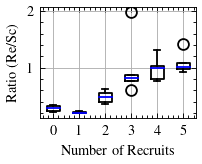

In [18]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
XX = 'Recruits'
BP = 'Robots'
fs = hlwidth
# df = df.query('Robots==20')

# Process the dataframe  
df['%DIST_RECRUIT'] = df['RECRUIT_DIST']/df['SCOUT_DIST']
df = df.groupby(['Robots', 'Recruits', 'REP'], as_index=False).agg({'%DIST_RECRUIT':'mean'})

# Create plot
bp = df.groupby(BP).boxplot(column=['%DIST_RECRUIT'], by=XX, sharey=True, layout=(2,2))

# Edit plot 
plt.suptitle('')
for ax in bp: ax.set_xlabel("Number of %s" % XX)
for ax in bp: ax.set_ylabel("Ratio (Re/Sc)")
for ax in bp: ax.set_title('') 
# plt.gcf().tight_layout()

plt.savefig("plots/experiment_"+EXP+"/ratio_bp_%s.png" % XX, bbox_inches='tight', dpi=600)
plt.show()

## Ticks per second (histogram)

Dropdown(description='Experiment:', index=16, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

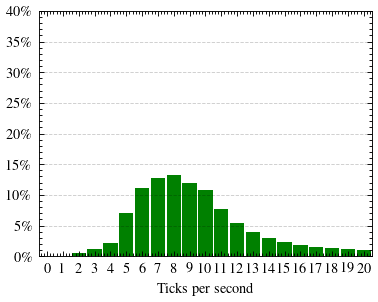

In [11]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'simulation')

# Process the dataframe 
df = df.get_param(df,'generic_params','tps')
bins = np.arange(df['tps'].min()-10, df['tps'].min()+12, 1)-0.5
xticks = np.arange(df['tps'].min()-10, df['tps'].min()+11, 1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPS'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0])*0.9, color='green')

# Edit plot
ax.grid(axis='y', linestyle='--', color='k', alpha=0.2, zorder=0) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 0.4)
ax.set_xticks(xticks)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Ticks per second')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/ticks_per_second.png", bbox_inches='tight')
plt.show()

## Blockchain Visualizer

In [ ]:
# Select which experiment to plot the whole blockchain
tic()
# Select what data to read
EXP = 'test115/20_blockchain2'
REP = ['002']
ID = range(1,100)

# Collect data
df = create_df(EXP, 'block')
df = df.query("REP in @REP")

# Remove duplicate blocks
df = df.drop_duplicates('HASH').sort_values('BLOCK')
genesis = df['PHASH'].iloc[0]
# display(df)
bc = create_digraph(df)
toc()
# mainchain_path is the longest path extracted with nx
bc_nx = convert_digraph(bc)
mainchain_path = get_mainchain(bc_nx, source=genesis, target=str(df['HASH'].iloc[-1]))

# Block hashes which are in mainchain_path -> mainchain 
df_mainchain = df.query("HASH in @mainchain_path")
# mainchain = create_digraph(df_mainchain)
# mainchain_nx = convert_digraph(mainchain)

# Block hashes not in the mainchain_path -> forks
df_forks = df.query("HASH not in @mainchain_path")
forks = create_digraph(df_forks)
forks_nx = convert_digraph(forks)

# Block hashes which are in forks, but are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')

# Block hashes which are in forks, are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')
toc()

# bc

In [ ]:
MIN_FORK_LENGTH = 0

fork_paths = [[y] for y in df_leafs['HASH']]
df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)

fork_paths_longer_than = paths_longer_than(fork_paths, MIN_FORK_LENGTH)

nodes_in_forks_longer_than = nodes_in_paths(fork_paths_longer_than)

df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @mainchain_path')
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')

# Do something cool? Idk, for example try to keep all forks at same level (slow!)
df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

# Save plot
bc_trimmed.render('plots/blockchain', format='pdf', view=True)
# bc_trimmed

## Robot Balances

In [ ]:
# Select which experiments to plot
EXP = 'test10'
NREP = ['001']

# Collect data
df = create_df(EXP, 'sc')
df = df.query("NREP in @NREP")

# Perform corrections
df = df.append(pd.Series(0, index=df.columns), ignore_index=True).sort_values('TIME')

# Create figure
ax = plt.axes()
df.set_index(['TIME']).groupby(['ID'])['BALANCE'].plot(ax = ax, alpha = 0.7)
ax.set_xlim(xmin=0,xmax = df['TIME'].max())
ax.legend(title='Robot ID')
ax.set_xlabel('Time [s]')
